## Context
A few years ago, I moved back to my family's farm near Charlotte, NC. While I know the macro trends of global warming, I was curious to see what I could learn about local patterns. Winters seem wetter than I remember and gardening recommendations around first and last frost seem to suggest winter is shorter.  
Beyond personal interest, hopefully my nascent Python skills are improving. 

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px 
from fbprophet import Prophet

### Problem Definition
Assess whether Charlotte's annual rainfall is changing and whether it is seasonally stable <br>
Assess whether Charlotte's avg temp is rising over time <br>
Determine if there is any clear trend in the date of first/last frost

In [2]:
#pulled from https://www.ncdc.noaa.gov/cdo-web/ which is a great resource for weather info dating back to 1800s
DATA_DIR = "C:\\Users\\xxx\\2 - Data"
weather = 'clt_airport_weather.csv'
df = pd.read_csv(os.path.join(DATA_DIR, weather), parse_dates=['DATE'])

In [3]:
#col name cleaner borrowed from a Medium post
def clean_col_names(df):
    """
    Simple function to convert the column 
    names of a dataframe to snake_case and lower case.
    """
    # Get all the col names as lower and snake_case in a list
    new_col_names = [column.strip().replace(' ', '_').lower() for column in df.columns]
    # Rename the column names
    df.columns = new_col_names
    return df


In [4]:
#prcp is rainfall in (in); tavg/max/min are daily temp ranges and avg in (f)
clean_col_names(df)

,station,name,date,prcp,tavg,tmax,tmin
0,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",1945-01-01,0.56,NaN,58,24
1,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",1945-01-02,0.00,NaN,41,19
2,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",1945-01-03,0.00,NaN,48,27
3,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",1945-01-04,0.06,NaN,49,33
4,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",1945-01-05,0.00,NaN,54,31
...,...,...,...,...,...,...,...
27811,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",2021-02-22,0.43,42.0,52,36
27812,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",2021-02-23,0.00,47.0,67,29
27813,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",2021-02-24,0.00,53.0,73,32
27814,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",2021-02-25,0.00,60.0,73,40


In [5]:
#dropping station and name as they're all identical at CLT airport
df.drop(['station','name'], axis=1, inplace=True)

In [6]:
df.set_index('date', inplace=True)

### Rainfall Trend and Analysis

In [7]:
#resample up to monthly level to assess trend
monthly_rain_df = df[['prcp']].resample('M').sum()

In [8]:
#renaming column to reflect data
monthly_rain_df.rename(columns={'prcp':'monthly_prcp'}, inplace=True)
monthly_rain_df.head()

,monthly_prcp
date,
1945-01-31,2.01
1945-02-28,5.10
1945-03-31,2.77
1945-04-30,3.50
1945-05-31,1.29


In [9]:
#checking df.loc functionality on year-month params
df.loc['1945-02','prcp'].sum()

5.1000000000000005

In [65]:
#no missing data, few huge rainfall events, maybe some multi-year seasonality?
fig = px.line(monthly_rain_df, title='Monthly Rainfall Totals (in)', labels={'value':'inches'}, template='plotly_white')
fig.show()

In [66]:
# a few outliers, but nothing seems errant
fig = px.box(monthly_rain_df['monthly_prcp'], title='Monthly Rainfall Distribution')
fig.show()

In [12]:
#not Hurricane Huge which hit in Sept. 1989
monthly_rain_df.nlargest(5,'monthly_prcp')

,monthly_prcp
date,
1990-10-31,14.72
1975-05-31,12.48
2003-05-31,10.69
1945-09-30,10.43
2003-08-31,10.35


In [15]:
#copying dataset to edit forecast df for time series modeling
monthly_fcast = monthly_rain_df.copy(deep=True)

In [16]:
monthly_fcast.reset_index(inplace=True)

In [17]:
#rename columns to 'ds' and 'y' for Prophet to decompose trend and seasonality of CLT rainfall
monthly_fcast.rename(columns={'date':'ds', 'monthly_prcp':'y'}, inplace=True)
monthly_fcast.set_index('ds')

,y
ds,
1945-01-31,2.01
1945-02-28,5.10
1945-03-31,2.77
1945-04-30,3.50
1945-05-31,1.29
...,...
2020-10-31,6.56
2020-11-30,6.67
2020-12-31,2.98


#### Prophet
While Prophet is incredibly easy to use, after reading this (https://www.microprediction.com/blog/prophet) I'm a little skeptical. That said, I'm not smart enough on time series forecasting and decomposition yet to choose a better option. I'm also skipping model validation here, so take the charts below with a healthy grain of salt.

In [18]:
#Instantiate model and fit to dataframe
rain_model = Prophet(interval_width=0.95)
rain_model.fit(monthly_fcast)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
#create future dates, use 'M' rather than 'MS' since existing df uses month end dates
future_dates = rain_model.make_future_dataframe(periods=36, freq='M')

In [20]:
rain_fcast = rain_model.predict(future_dates)

Text(103.5, 0.5, 'Inches Rainfall')

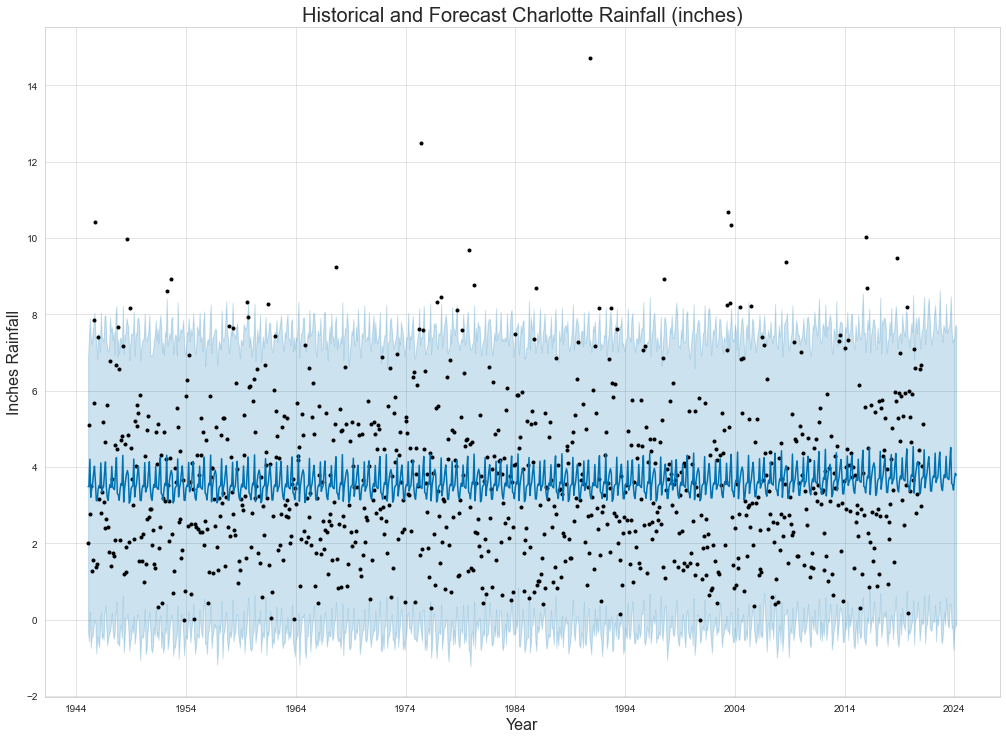

In [21]:
#little visible trend although slightly upward trend in recent years?, clear seasonality
fig = rain_model.plot(rain_fcast, uncertainty=True, figsize=(14,10))
ax = fig.gca()
ax.set_title('Historical and Forecast Charlotte Rainfall (inches)', size=20)
ax.set_xlabel('Year', size=16)
ax.set_ylabel('Inches Rainfall', size=16)

Text(103.5, 0.5, 'Seasonality')

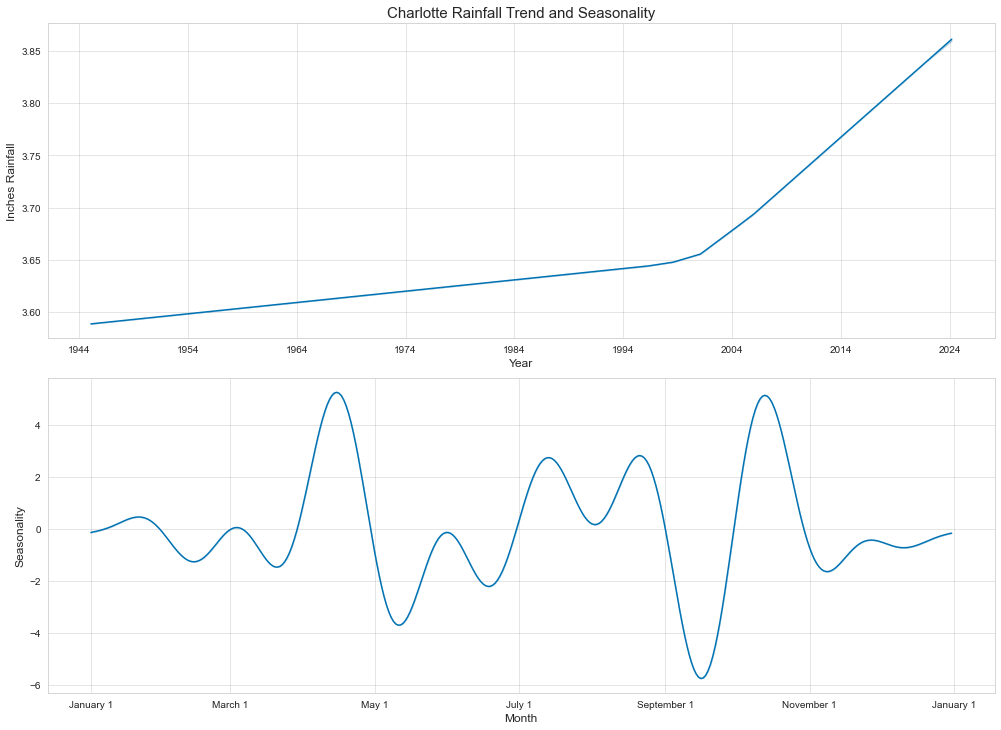

In [22]:
#Seasonal decomposition and trend. The upward trend looks alarming but note scale
fig = rain_model.plot_components(rain_fcast, uncertainty=True, figsize=(14,10))
axes = fig.get_axes()
axes[0].set_title('Charlotte Rainfall Trend and Seasonality', size=15)
axes[0].set_xlabel('Year', size=12)
axes[0].set_ylabel('Inches Rainfall', size=12)
axes[1].set_xlabel('Month', size=12)
axes[1].set_ylabel('Seasonality', size=12)

## Temperature Forecast and Trend Analysis

In [23]:
#resampling to look at monthly avg. temp data in hopes of seeing better trends
monthly_temp = df[['tmin','tmax']].resample('M').mean()

In [24]:
monthly_temp.head()

,tmin,tmax
date,,
1945-01-31,31.419355,50.451613
1945-02-28,36.214286,55.607143
1945-03-31,48.677419,72.064516
1945-04-30,51.566667,73.633333
1945-05-31,54.387097,77.064516


In [67]:
#perhaps some slight upward trend in avg monthly temp; seems most noticeable between 2010 and 2020
#chart is definitely a little noisy but with Plotly you can easily zoom in/pan/etc.
fig = px.line(monthly_temp[['tmax', 'tmin']], template='plotly_white', color_discrete_sequence=['green', 'blue'],
       title='Avg Monthly High and Low Temp(F)', labels={'value':'degrees(F)', 'date':'year'})
fig.show()

In [30]:
#assessing trend and forecasting on monthly avg. high temp
monthly_temp_high = monthly_temp.drop('tmin', axis=1)
monthly_temp_high.reset_index(inplace=True)

In [31]:
#renaming columns for prophet
monthly_temp_high.rename(columns={'date':'ds','tmax':'y'}, inplace=True)

In [32]:
#set index to ds for prophet
monthly_temp_high.set_index('ds')

,y
ds,
1945-01-31,50.451613
1945-02-28,55.607143
1945-03-31,72.064516
1945-04-30,73.633333
1945-05-31,77.064516
...,...
2020-10-31,75.806452
2020-11-30,68.400000
2020-12-31,54.483871


In [34]:
#instantiate and fit model
monthly_high_model = Prophet(interval_width=0.95)
monthly_high_model.fit(monthly_temp_high)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
#set future dates 5 years ahead by month (ensure future periods are same as historical periods (i.e. months and months))
future_dates = monthly_high_model.make_future_dataframe(periods=60, freq='M')

In [36]:
#forecast values based on future dates
monthly_high_model_fcast = monthly_high_model.predict(future_dates)

Text(98.125, 0.5, 'Temp (F)')

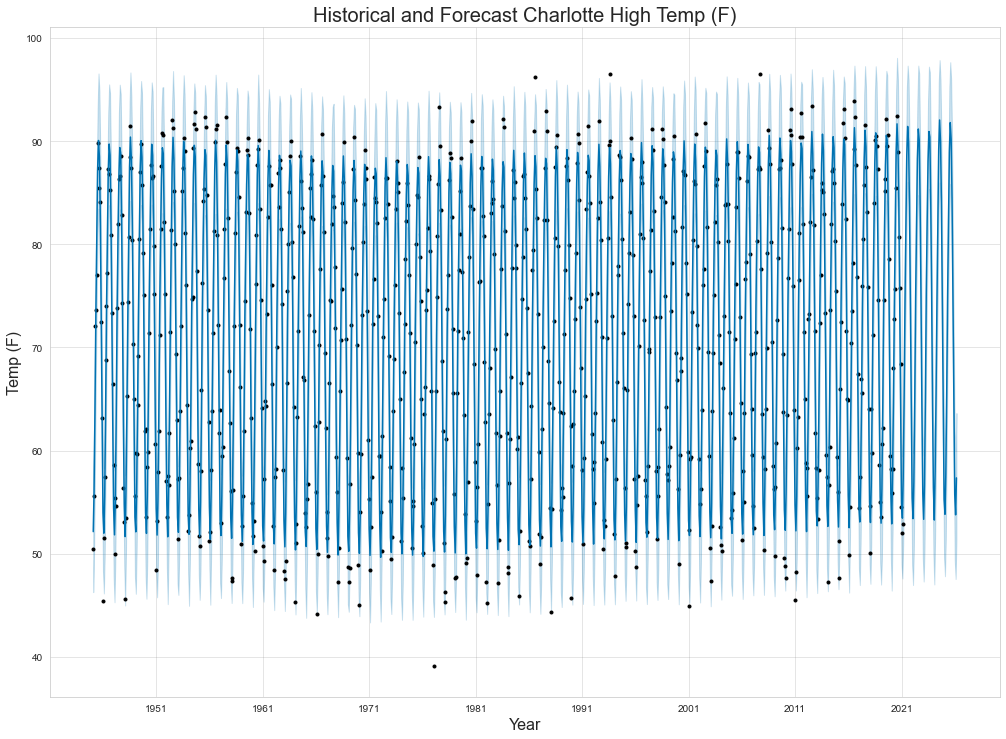

In [37]:
#Historical and forecast trend plus confidence interval
fig = monthly_high_model.plot(monthly_high_model_fcast, uncertainty=True, figsize=(14,10))
ax = fig.gca()
ax.set_title('Historical and Forecast Charlotte High Temp (F)', size=20)
ax.set_xlabel('Year', size=16)
ax.set_ylabel('Temp (F)', size=16)

Text(97.875, 0.5, 'Seasonality')

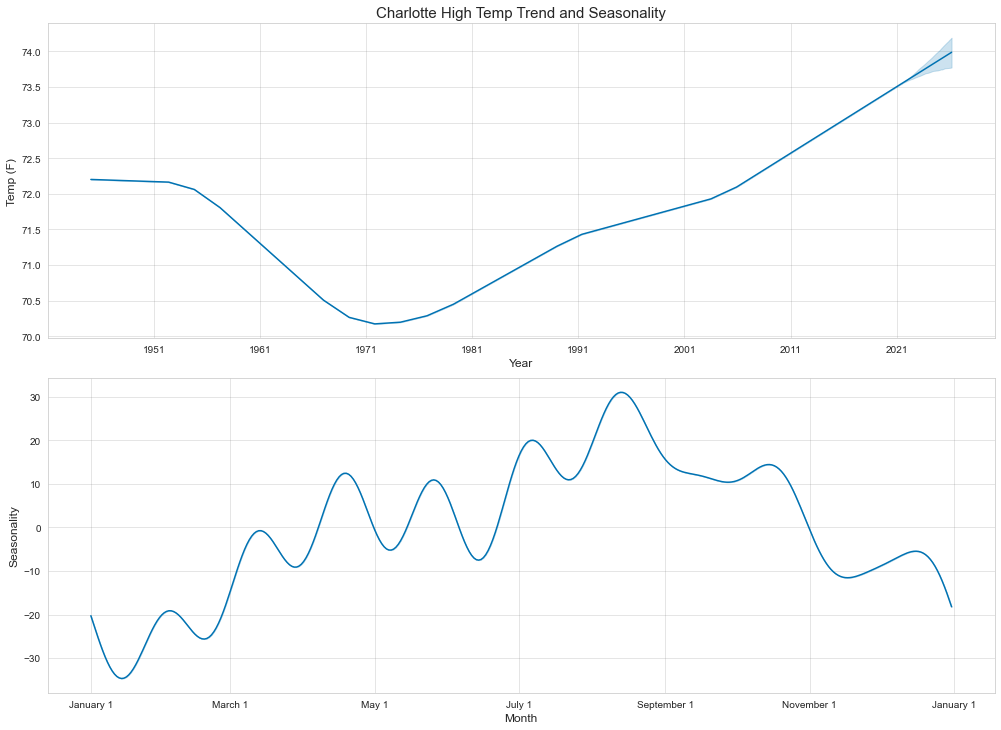

In [38]:
#Seasonal decomposition and trend. The upward trend looks (is) alarming but note scale
fig = monthly_high_model.plot_components(monthly_high_model_fcast, uncertainty=True, figsize=(14,10))
axes = fig.get_axes()
axes[0].set_title('Charlotte High Temp Trend and Seasonality', size=15)
axes[0].set_xlabel('Year', size=12)
axes[0].set_ylabel('Temp (F)', size=12)
axes[1].set_xlabel('Month', size=12)
axes[1].set_ylabel('Seasonality', size=12)

## How are frost dates changing over time?

In [40]:
#Adding columns for years and quarters to allow separation of years and year segments
df['year'] = df.index.year
df['quarter'] = df.index.quarter

In [48]:
#Want to calculate the max date when the temp is < 33 in the first two quarters
#Want to calculate the min date when the temp is < 33 in the last two quarters
end_of_winter = df[df['quarter'].isin([1,2])]
start_of_winter = df[df['quarter'].isin([3,4])]

In [49]:
#resetting index for ease of manipulation below
end_of_winter.reset_index(inplace=True)

In [50]:
#this took me awhile and a bit of stackoverflow digging, but I'm looking for the max date when the temp is below 33 and 
#then grouping by year to return one date per year as a dataframe
#where "last frost" is the last frost before spring
last_frost = pd.DataFrame(end_of_winter['date'].where(end_of_winter['tmin'] < 33).groupby(end_of_winter['year'])
                          .transform('max').unique())

In [51]:
#renaming single column produced above and adding year and day-of-year column for graphing
last_frost.columns = ['frost_date']
last_frost['year'] = last_frost['frost_date'].dt.year
last_frost['day_of_year'] = last_frost['frost_date'].dt.dayofyear 

In [68]:
#there's likely a more elegant way to do this but using day_of_year was the best I could figure out
fig = px.scatter(last_frost, x='year', y='day_of_year', trendline='ols', template='plotly_white', 
                 title='Last Winter Frost by Days since Jan 1. (1945-2020)')
fig.show()

The linear trendline doesn't offer much of a fit but makes a weak suggestion for date of the last frost to be trending down. The rule of thumb around here has always been that planting before Apr. 15th is risky. It hasn't officially changed with the local extension office, perhaps with some justificaton(?) but most folks are planting closer to Apr 1. 

In [53]:
#Same as above for start of winter
start_of_winter.reset_index(inplace=True)

In [58]:
#In this case, we want the 'first frost' of winter, so the min date during the second half of the year when the 
#temp is below freezing
first_frost = pd.DataFrame(start_of_winter['date'].where(start_of_winter['tmin']<33).groupby(start_of_winter['year'])
                          .transform('min').unique())

In [59]:
first_frost.columns = ['frost_date']
first_frost['year'] = first_frost['frost_date'].dt.year
first_frost['day_of_year'] = first_frost['frost_date'].dt.dayofyear 

In [69]:
fig = px.scatter(first_frost, x='year', y='day_of_year', trendline='ols', template='plotly_white', 
                 title='First Winter Frost by Days since Jan.1 (1945-2020)')
fig.show()

This trendline fits even less but also displays a slight downward trend. In this case, that would suggest that the first frost of winter is trending _earlier_ in the year. Traditionally, Oct. 15th is the rule of thumb around here, but again many folks tend to assume that they have until early November before first frost. 

### Summary
Per Prophet monthly average temperature and rainfall are both trending up and forecast to continue. But there's a caveat in Prophet's forecast methodology and I didn't do any validation of either model.  
Analysis of the last frost date is less clear, especially given some poor fitting trendlines.  
On the upside, I learned a good bit about Prophet, Plotly Express, and manipulating data to meet multiple conditions. Maybe I'll revisit both as I get a little smarter on time series analysis and forecasting.